# Data tidying

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from osgeo import gdal
import xarray as xr

## Data exploration
Loading the data and transforming to geopandas.

In [2]:
df = pd.read_pickle('../Data/prosperpolder.pkl')
df5000 = df.sample(5000, random_state=856)

vars_list = list(df.columns[range(4,10)])

Then the data is transformed to a geodataframe:

In [3]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(x=df['x'], y=df['y']), crs="EPSG:32631")
gdf5000 = geopandas.GeoDataFrame(df5000, geometry=geopandas.points_from_xy(x=df5000['x'], y=df5000['y']), crs="EPSG:32631")

## Interpolation (IDW)

In [4]:
# Function to easily interpolate the dataset using IDW

def IDW(power, output_file, input_file, width, height, zfield, radius):
    options = gdal.GridOptions(format="GTiff", 
                               outputSRS="EPSG:32631", 
                               algorithm=("invdist:power="+str(power)+":radius1="+str(radius)+":radius2="+str(radius)+":nodata=-999.0"), #Nan=-999
                               width=width, height=height, zfield=zfield)
    raster = gdal.Grid(output_file, input_file, options=options )
    raster = None

### Test with 5000 random observations

In [5]:
# gdf5000.to_file("../Data/Data_geojson/gdf5000.geojson", driver="GeoJSON")
multipoints = gdf5000.dissolve()
bounds = multipoints.bounds.squeeze()

**Change long path!! (When everything is in same Git folder)** 

In [6]:
xres = 10
yres = 10
w = round((bounds['maxx'] - bounds['minx'])/xres)
h = round((bounds['maxy'] - bounds['miny'])/yres)
raster = IDW(2, "Interpolations/test.tiff", "../Data/Data_geojson/gdf5000.geojson", w, h, 'HCP4QP', radius=50)

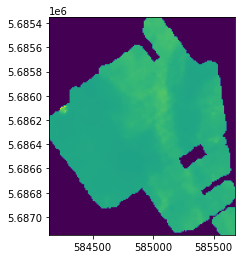

In [7]:
# Visualization of the interpolation using rasterio
import rasterio
from rasterio.plot import plotting_extent
with rasterio.open("Interpolations/test.tiff") as src:
    test = src.read()
    test_extent = plotting_extent(src)
    
plt.imshow(test.transpose(1,2,0), extent=test_extent, origin='lower')

### Interpolation for all layers using IDW, power = 2, res=10mx10m

In [26]:
# gdf.to_file('../Data/Data_geojson/gdf.geojson', driver='GeoJSON')

# Set parameters:
xres = 10
yres = 10
w = round((bounds['maxx'] - bounds['minx'])/xres)
h = round((bounds['maxy'] - bounds['miny'])/yres)
r = 30

for var in vars_list:
    raster = IDW(2, "Interpolations/IDW_10" + 
                 var + ".tiff", "../Data/Data_geojson/gdf.geojson", w, h, zfield=var, radius=r)

## Turn interpolations into dataframe

Will be needed as input to clustering algorithms

In [29]:
vars_vec = df.columns[range(4,10)]

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1
    
stack_array = stack_data.to_array(dim="band")

df_raster = stack_data.to_dataframe()[vars_vec]

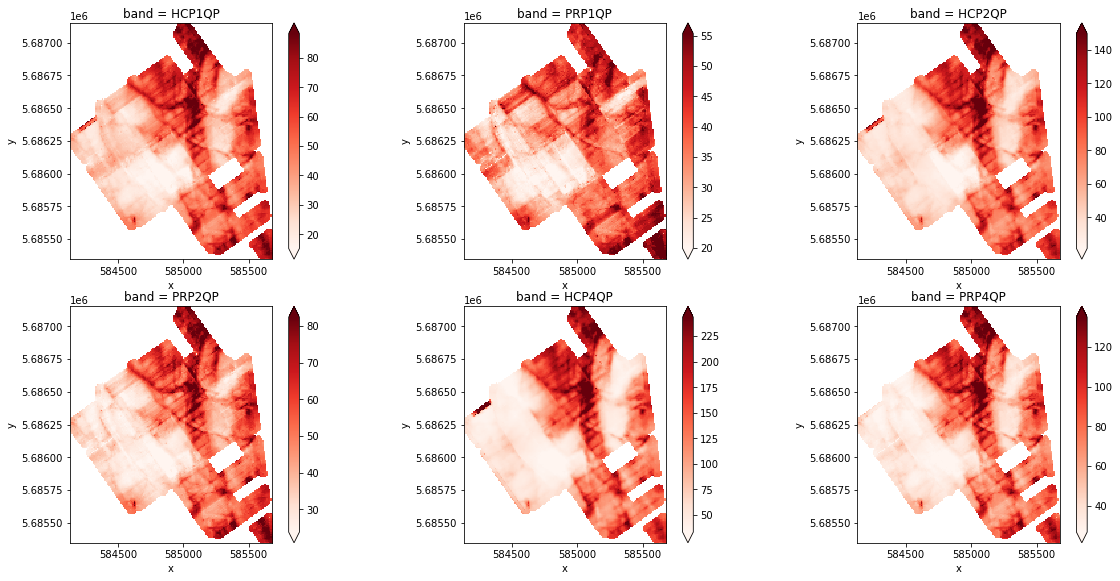

In [30]:
stack_array = stack_data.to_array(dim="band")

fig = plt.figure(figsize=(20,20))

i=1
for var in vars_vec:
    ax = fig.add_subplot(4,3,i)
    ax = stack_array.sel(band=var).plot.imshow(robust=True, cmap="Reds")
    ax.axes.set_aspect('equal')
    i += 1


### PCA on the raster data

In [31]:
from sklearn import preprocessing as prep


rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[vars_vec][~rows_with_nan]
df_std = np.array(prep.StandardScaler().fit_transform(df_nona))

U, delta, Vt = np.linalg.svd(df_std, full_matrices=0)


% variance explained by 2 PC's=98.55684688293692


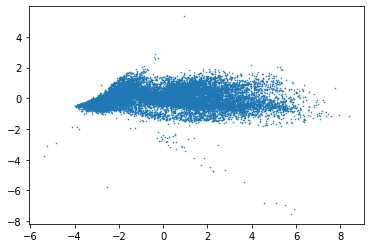

In [32]:
rel_var = delta**2/ sum(delta**2) *100

#plt.bar(range(1,13), rel_var)

print("% variance explained by 2 PC's=" + str(rel_var[:2].sum()))

# To plot the data in 2 dimensions:
delta_k = np.diag(delta[range(2)])
Uk = U[:, 0:2]
Zk = np.matmul(Uk, delta_k)

plt.scatter(x=Zk[:,0], y=Zk[:,1], s=0.3)
plt.show()

Several areas with a high concentration of points, these could be relevant clusters.\
Maybe these just correspond to the different 'surveys'?

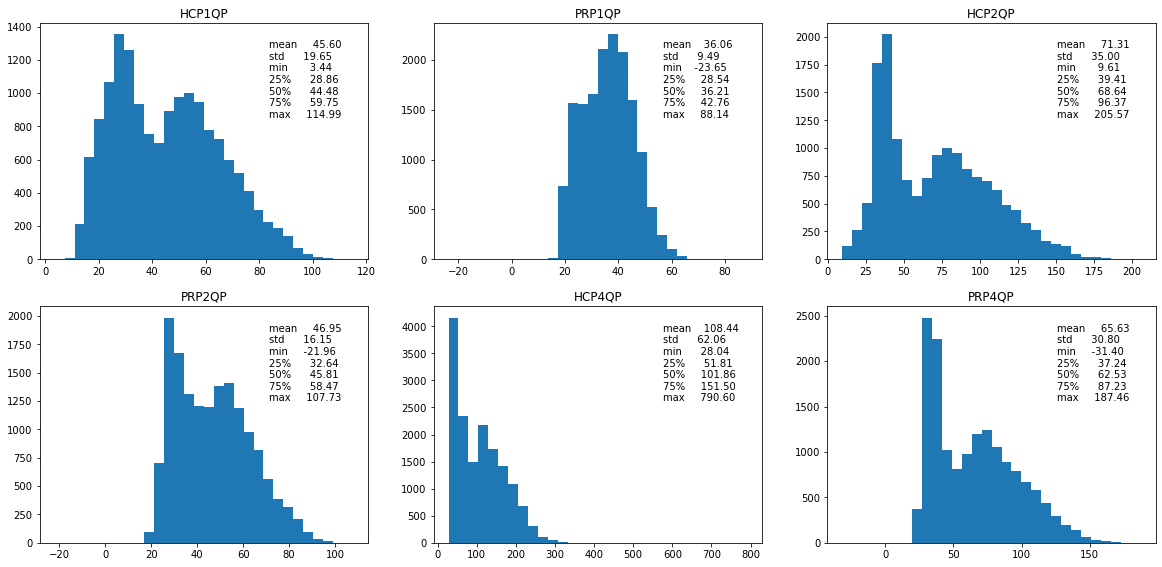

In [33]:
fig = plt.figure(figsize=(20,20))

i=1
for var in vars_list:
    ax = fig.add_subplot(4,3,i)
    ax.hist(df_nona[var], bins=30)
    ax.title.set_text(var)
    i += 1
    ax.annotate(text=df_nona[var].describe().round(decimals=2).loc[['mean','std','min','25%','50%','75%','max']].to_string(), 
                xy=(0.7,0.6), xycoords='axes fraction')

The distributions seem to be bimodal.

In [34]:
corr = df_nona[vars_list].corr()
corr.style.background_gradient(cmap='coolwarm')

,HCP1QP,PRP1QP,HCP2QP,PRP2QP,HCP4QP,PRP4QP
HCP1QP,1.000000,0.853321,0.981664,0.972132,0.934263,0.967985
PRP1QP,0.853321,1.000000,0.762698,0.900009,0.665545,0.775442
HCP2QP,0.981664,0.762698,1.000000,0.946908,0.972100,0.981242
PRP2QP,0.972132,0.900009,0.946908,1.000000,0.873248,0.965456
HCP4QP,0.934263,0.665545,0.972100,0.873248,1.000000,0.938685
PRP4QP,0.967985,0.775442,0.981242,0.965456,0.938685,1.000000
